In [77]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


-----------------------
def  Critério_1
Aptidão do indivíduo é menor ou igual que (1 + parametro_perc) * aptidão do melhor indivíduo

Para todos os indivíduos da pop atual
Se individuo atende ao critério 1
     inserir HOF
Se lista vazia
          inserir individuo
     Senão
          Se individuo é diferente de todos da lista
                inserir individuo
-----------------------
def compararIndividuosSelecionados():
Para todos indivíduos da lista
       def Calcular Diff - diferença entre as variáveis de indivíduo e individuo lista
       Se Diff não é maior que parâmetro_diff em mais de parâmetro_var -> numero de variaveis diferentes (min 2) 
             Retorna falso
Fim Para
Retorna verdadeiro



In [78]:


def  calculaCandidatosElite( new_pop, porcentagem, k= 30):
    """Seleciona os candidatos ao conjunto elite com base nas diferenças percentuais de aptidão."""
    print(f"CRITÉRIO 1 RCE - Selecionando candidatos ao conjunto elite")
    elite_individuals = []

    # Obter o melhor indivíduo (HOF) da população
    best_ind = new_pop[0]
    best_fitness = best_ind.fitness.values[0]

    # Ordenar a população em ordem crescente de aptidão e selecionar os k primeiros indivíduos
    sorted_population = sorted(self.POPULATION, key=lambda x: x.fitness.values[0])

    max_difference = (1 + porcentagem) * best_fitness
    for ind in sorted_population:
       
        if ind.fitness.values[0] <= max_difference:
            elite_individuals.append(ind)
        else:
            break  # Parar a seleção quando a diferença percentual for maior que o limite
    return elite_individuals


def criterio1_refatorado(self, new_pop, porcentagem, k= 30):
    elite_individuals = []

 
    for ind in self.POPULATION:
        if (calculaCandidatosElite(ind)):
                    # Obter o melhor indivíduo (HOF) da população
            best_ind = new_pop[0]
            best_fitness = best_ind.fitness.values[0]
        if elite_individuals == []:
            elite_individuals.append(ind)

        elif compararIndividuosSelecionados(elite_individuals):
            elite_individuals.append(ind)
    
    return elite_individuals


def CalcularDiff(individuos):
    # diferença entre as variáveis de indivíduo e individuo lista
    pass

def compararIndividuosSelecionados(lista,delta = 8, numVar = 2):
    for individuos in lista:
       Diff = CalcularDiff(individuos)
       if Diff > delta and len(Diff) > numVar:
           return False
    return True


[ ] Corrigir conjunto elite - Set()

[] Dados entrada do Framework com GUI

[ ] Criterio 2 alternative

[ ] Implementação do programa e simulações do Alg Evolutivo

[ ] Coleta e analise de dados

- Ajustar os aleatórios do RCE.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive

11ª Reunião (Remota)
- Verificar pendências
- Ajustar o RCE, seguindo passo a passo no chat do google.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive
- Tipo, qtde e limite de variáveis de decisão são dados de entrada e impactam em ajuste da função individual do DEAP (isso será visto depois).
- Verificar se a explicação do resultado e os gráficos estão corretos.

## Classe Setup 

In [79]:
class Setup:
    def __init__(self, params):

        #! Parametros JSON
        self.params = params
        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.SIZE_INDIVIDUAL = params["IND_SIZE"]
        self.TAXA_GENERATION = params["RCE_REPOPULATION_GENERATIONS"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENERATIONS, self.POPULATION_SIZE = (
            self.CXPB,
            self.MUTPB,
            self.NGEN, 
            self.POP_SIZE,
        )

        #! Parametros do algoritmo de Rastrigin
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENERATIONS * self.TAXA_GENERATION)
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        # creator.create("Individual", list, fitness=creator.Fitness)

        self.dataset = {}
        self.beta_constants = {}

        #!Criando individuo pelo deap com seus atributos
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create(
            "Individual", list, fitness=creator.FitnessMin, rce=str, index=int
        )
        self.toolbox = base.Toolbox()

        # todo gerando atributos ao ind
        self.toolbox.register(
            "attr_rce", random.uniform, 0.0, 9.9
        )  
        self.toolbox.register("attr_int", random.uniform, 1, 1000)

        # Variavel de decisão
        self.toolbox.register("attribute", random.uniform, -5.12, 5.12)

        # registrando os individuos
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )

        #! paramentos evolutivos
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):
        if self.type == "minimaze":
            result = minimize(
                self.rastrigin, x0=np.zeros(self.SIZE_INDIVIDUAL), method="BFGS"
            )
            fitness_value = result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENERATIONS,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)


class DataExploration:
    def __init__(self):
        self.fit_array = []

    def default_rastrigin(self,x, y):
        return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))


    def generateSimpleDataset(self):
        # Geração dos dados
        data = pd.DataFrame(
            {
                'x': np.linspace(-5, 5, 400),
                'y': np.linspace(-5, 5, 400)
            }

        )

        #display(data)

        # Generate meshgrid data
        x = np.linspace(-5.15, 5.15, 100)
        y = np.linspace(-5.15, 5.15, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate function values
        #print(X.shape,Y.shape)

        return X,Y

    def plot_Rastrigin_2D(self,X, Y, Z_rastrigin,logbook ,best_variables =[] ):
        fig = plt.figure(figsize=(18, 10))
        ax1 = fig.add_subplot(231)
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        line1 = ax1.plot(generation, statics["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(generation, statics["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(generation, statics["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        ax1.set_title("GERAÇÃO X FITNESS")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")


        # Rastrigin 2D
        ax2 = fig.add_subplot(232)
        ax2.contourf(X, Y, Z_rastrigin, levels=50, cmap='viridis')
        #ax2.plot(best_variables, color='red',)
        for num in range(len(best_variables)):
            var_x = round(best_variables[num])
            var_y = best_variables[num]
            ax2.scatter(var_x,var_y, color = "pink",    marker="o" , label='best variables')
        ax2.set_title('Rastrigin Function 2D')
        ax2.set_xlabel("X")
        ax2.set_ylabel('Y')


        #Rastrigin 3D
        ax5 = fig.add_subplot(233, projection='3d')
        ax5.plot_surface(X, Y, Z_rastrigin, cmap='viridis', edgecolor='none')
        ax5.set_title('Rastrigin Function 3D')
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('Z')

        plt.tight_layout()
        plt.show()


    def show_rastrigin_benchmark(self,logbook,best = []):
        X,Y = self.generateSimpleDataset()

        Z_3D_rastrigin = self.default_rastrigin(X,Y )

        self.plot_Rastrigin_2D(X, Y, Z_3D_rastrigin,logbook,best)    

    def statistics_per_generation_df(self, logbook):
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")
        max_fitness = logbook.select("max")
        std_fitness = logbook.select("std")

        data = {
            "Generation": generations,
            "Min Fitness": min_fitness,
            "Average Fitness": avg_fitness,
            "Max Fitness": max_fitness,
            "Std Fitness": std_fitness,
        }

        df = pd.DataFrame(data)
        display(df)

    def plot_diversidade_genes(self, population):
        print("Plotando diversidade dos genes")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        x_values = [ind[0] for ind in population]  # Retorna a primeira posição do vetor
        y_values = [ind[1] for ind in population]  # Retorna a segunda posição do vetor

        ax.scatter(x_values, y_values, c="b", label="Population")
        ax.set_title("Diversity of genes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()

    def plot_scatter_turbina(self, turbina, best_variables):
        # Plotar o gráfico de dispersão
        plt.figure(figsize=(10, 6))

        plt.scatter(
            turbina["Curva_Teórica(KWh)"],
            turbina["ActivePower(kW)"],
            label="Dados Reais",
            color="blue",
        )
        plt.plot(
            turbina["Curva_Teórica(KWh)"],
            best_variables * turbina["Curva_Teórica(KWh)"],
            label="Melhor Solução",
            color="red",
        )

        plt.xlabel("Potência Teórica (KWh)")
        plt.ylabel("Potência Ativa (kW)")
        plt.title("Comparação entre Potência Teórica e Potência Ativa")
        plt.legend()
        plt.grid(True)
        plt.show()

    def displayDataFrameInfo(self, array, text):
        # Criar DataFrame com as melhores soluções
        best_df = pd.DataFrame(array)
        self.cout(text)
        display(best_df)
        return best_df
    
    def show_conjuntoElite(self, pop):
        print("\n\n-->Conjunto Elite:", pop)
        best_df = pd.DataFrame(pop)
        display(best_df.sort_values(by = "Fitness" ,ascending=False))



    def calculate_stats(self, logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)

        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness": fit_avg,
            "std_fitness": fit_std,
        }

    def rastrigin(self, x):
        A = 10
        return A * len(x) + sum(
            [(x[i] ** 2 - A * np.cos(2 * math.pi * x[i])) for i in range(len(x))]
        )

    def cout(self, msg):
        print("==========================================================================================")
        print(msg)
        print("==========================================================================================")

    def visualize(self, logbook, pop, problem_type="minimaze", repopulation=True):
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)

        if problem_type == "maximize":
            # Se o problema for de maximização, inverter os valores de fitness para exibir corretamente o gráfico
            statics = {
                key: [-value for value in values] for key, values in statics.items()
            }

        if repopulation:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = pop[best_solution_index]
            best_solution_fitness = statics["min_fitness"][best_solution_index]
        else:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = logbook.select("min")
            best_solution_fitness = min(statics["min_fitness"])

        # Soluções do problema
        self.cout("Soluções do problema")
        print("\nBest solution index = ", best_solution_index)
        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        try:
            # Encontrar o ótimo global da função Rastrigin usando os valores fornecidos.
            opt = minimize(
                self.rastrigin, best_solution_variables, method="Nelder-Mead", tol=1e-6
            )
            print("\nÓtimo global da função Rastrigin = ", opt.fun)
            print("\nSolução ótima global = ", opt.x)
            # Comparar as soluções obt
            print(
                "\nPorcentagem de proximidade da solução em relação ao ótimo global = ",
                (1 - (best_solution_fitness / opt.fun)) * 100,
                "%",
            )
            distancia_otimoglobal = abs
            print(
                f"\nDistância da solução em relação ao ótimo global = {distancia_otimoglobal}",
            )

            self.grafico_convergencia(generation, statics, repopulation)
            self.graficoBarrasFitnessGeneration(generation, statics, repopulation)
        except:
            print("Erro validation :(")

    def grafico_convergencia(self, gen, lista, repopulation=False):
        fig, ax1 = plt.subplots()
        if repopulation:
            ax1.set_title("Com Repopulação")
        else:
            ax1.set_title("Sem Repopulação")

        

        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

    def plot_grafico_barras(self, x, y):
        fig, ax = plt.subplots()
        ax.bar(x, y, color="b")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness por Geração")
        plt.show()

    def graficoBarrasFitnessGeneration(self, generation, lista, repopulation=False):
        fig, ax = plt.subplots()
        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        if len(generation) > 1:
            best_solutions = [min(lista["min_fitness"]) for i in range(len(generation))]
            avg_fitness = lista["avg_fitness"]
            generations = np.arange(1, len(generation) + 1)

            ax.plot(
                generations,
                avg_fitness,
                marker="o",
                color="r",
                linestyle="--",
                label="Média Fitness por Geração",
            )
            ax.bar(generations, lista["min_fitness"], color="green", label="Melhor Fitness por Geração",  )

            ax.set_xlabel("Geração")
            ax.set_ylabel("Fitness")
            ax.set_title("Melhor Fitness e Média por Geração")
            ax.legend()
            plt.show()


    def plot_diversidade(self, population, repopulation=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]
        z_values = [ind[2] for ind in population]

        ax.scatter(x_values, y_values, z_values, c="b", label="Population")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        ax.grid(True)

        plt.show()

In [80]:
def selecionar_individuos(populacao, parametro_perc, parametro_diff, parametro_var):
    selecionados = []

    def criterio_2_alternativa(individuo, lista):
        melhor_aptidao = min(
            [i[1] for i in lista]
        )  # Obtém a aptidão do melhor indivíduo na lista
        return individuo[1] <= (1 + parametro_perc) * melhor_aptidao

    def diff_maior_que_parametro(individuo, individuo_lista):
        diff = sum(abs(a - b) for a, b in zip(individuo[0], individuo_lista[0]))
        return diff <= parametro_diff * parametro_var

    def compara_com_lista(individuo, lista):
        for individuo_lista in lista:
            if not diff_maior_que_parametro(individuo, individuo_lista):
                return False
        return True

    for novo_individuo in populacao:
        if not selecionados:
            selecionados.append(novo_individuo)
        elif criterio_2_alternativa(novo_individuo, selecionados) and compara_com_lista(
            novo_individuo, selecionados
        ):
            selecionados.append(novo_individuo)

    return selecionados


# Exemplo de uso
populacao = [[(1, 2, 3), 10], [(2, 3, 4), 8], [(0, 1, 2), 12]]
parametro_perc = 0.1
parametro_diff = 0.2
parametro_var = 0.05

selecionados = selecionar_individuos(
    populacao, parametro_perc, parametro_diff, parametro_var
)
print("Indivíduos selecionados:", selecionados)

Indivíduos selecionados: [[(1, 2, 3), 10]]


## Algoritimo Evolutivo RCE

In [81]:
class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.POPULATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.POPULATION)

        self.pop_RCE = []
        self.best_solutions_array = []
        self.best_individual_array = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    def pesquisarLinear(self,array,num,pos=0):
        while ((pos < len(array)) and (array[pos] != num)):
            pos += 1

        if array[pos] == num:
            print("Valor encontrado")

    def registrarDados(self,generation):

        # Registrar estatísticas e melhores soluções
        for ind in self.POPULATION:
            avg_fitness_per_generation = np.mean(ind.fitness.values)
            std_deviation = np.std(ind.fitness.values)

        #! PEgandos os dados e colocando no df
        self.data = {
            "Generations": generation + 2,
            "Variaveis de Decisão": self.hof[0],
            "Evaluations": self.setup.evaluations,
            "Ind Valido":self.hof[0].fitness.valid,
            "Best Fitness": self.hof[0].fitness.values,
            "Media": avg_fitness_per_generation,
            "Desvio Padrao": std_deviation,
        }

        self.best_individual_array.append(self.data)

        self.visualizarPopAtual(
            generation, [avg_fitness_per_generation, std_deviation]
        )

    def checkClonesInPop(self, ind, new_pop):
        is_clone = False
        for other_ind in new_pop:
            if (
                ind == other_ind
                and sum(ind) == sum(other_ind)
                and ind.index != other_ind.index
            ):
                is_clone = True
                break
        return is_clone

    def generateInfoIndividual(self, new_pop, generation):
        ind_array = []

        for i, ind in enumerate(new_pop):
            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")

            ind.index = i

            ind_info = {
                "Generations": generation,
                "index": ind.index,
                "Variaveis de Decisão": ind,
                "Fitness": ind.fitness.values[0],
                "RCE": ind.rce,
                "Diversidade": np.sum(ind),
            }

            # Adicionar a informação de clone ao dicionário
            is_clone = self.checkClonesInPop(ind, new_pop)
            ind_info["CLONE"] = "SIM" if is_clone else "NAO"

            ind_array.append(ind_info)

        return ind_array

    def show_ind_df(self, array, text):
        df = pd.DataFrame(array)
        print(text)
        display(df.head(40))

        # contar quantos SIM na coluna CLONE se a coluna RCE for SIM
        display(df[df["RCE"] != ""]["CLONE"].value_counts())

    def criterio1(self,new_pop):
        """Pega  30% do valor dos melhores fitness do HOF de cada geração."""
        self.cout(f"CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração")
        elite_size = int(0.3 * len(self.POPULATION))

        sorted_population = sorted(
            self.POPULATION, key=lambda x: x.fitness.values[0]
        )  # pop atual nao aleatória

        # Selecionar os 30% primeiros indivíduos (os de menor fitness)
        elite_individuals = sorted_population[:elite_size]

        # Clonar os indivíduos selecionados para a nova população aleatória e marcar como RCE
        for i, ind in enumerate(elite_individuals, start=0):
            new_pop[i] = self.setup.toolbox.clone(ind)             
            new_pop[i].rce = "SIM_1"

        return elite_individuals

    def criterio1_refatorado(self, new_pop, porcentagem, k= 30):
        """Seleciona os candidatos ao conjunto elite com base nas diferenças percentuais de aptidão."""
        self.cout(f"CRITÉRIO 1 RCE - Selecionando candidatos ao conjunto elite")
        elite_individuals = []

        # Obter o melhor indivíduo (HOF) da população
        best_ind = new_pop[0]
        best_fitness = best_ind.fitness.values[0]

        # Ordenar a população em ordem crescente de aptidão e selecionar os k primeiros indivíduos
        sorted_population = sorted(self.POPULATION, key=lambda x: x.fitness.values[0])
        # sorted_population = sorted_population[:k]

        max_difference = (1 + porcentagem) * best_fitness

        # Selecionar com as menores diferenças percentuais
        for ind in sorted_population:
            # fitness_difference = best_fitness - ind.fitness.values[0]
            # print(                f"Best: {round(max_difference,2)} x dif percentual: {round(fitness_difference,2)}"            )
            if ind.fitness.values[0] <= max_difference:
                elite_individuals.append(ind)
            else:
                break  # Parar a seleção quando a diferença percentual for maior que o limite

        # Colocando na pop aleatória
        print(
            f"Calculando percentual de {porcentagem*100}% com base no melhor fitness = {best_fitness} e pegando os {len(elite_individuals)} melhores.\n Porcentagem de {best_fitness} = {max_difference} "
        )
        for i, ind in enumerate(elite_individuals):
            new_pop[i] = self.setup.toolbox.clone(ind)             
            new_pop[i].rce = "SIM_1"

        return elite_individuals

    def aplicar_RCE(self, generation):
        ConjuntoEliteRce = set()
        array = []
        #! a - Cria uma pop aleatória (eliminando a pop aleatória criada na execução anterior do RCE)
        new_pop = self.setup.toolbox.population(n=self.setup.POP_SIZE) # retorna uma lista de individuos de var de decisao

        # Avaliar o fitness da população atual
        self.avaliarFitnessIndividuos(self.POPULATION)
        self.calculateFitnessGeneration(self.POPULATION)

        #! b - Coloca o elite hof da pop anterior  no topo (0)
        pop = self.elitismoSimples(self.POPULATION)
        print(f"Elitismo HOF Index[{pop[0].index}] {pop[0]} \n Fitness = {pop[0].fitness.values} | Diversidade = {sum(pop[0])}") # pop[0] é o melhor individuo HOF
        new_pop[0] = self.setup.toolbox.clone(pop[0])

        #! critério 1 e obtém os N melhores com 30% do valor do melhor fitness
        ind_selecionados = self.criterio1_refatorado(self.POPULATION, 0.30, k = 30)
        # ind_array = self.generateInfoIndividual(new_pop, generation)
        # self.show_ind_df(ind_array, "Individuos da nova população aleatória")

        #! Critério 2 usando este array e vai colocando os indivíduos selecionados pelo critério 2 na pop aleatória (passo a)
        ind_diferentes_var = self.criterio2(ind_selecionados, delta=7) 
        print("Set conjunto Elite (sem clones) = ",len(self.CONJUNTO_ELITE_RCE))

        #!debug conjunto elite
        try:
            for ind in self.pop_RCE:
                ConjuntoEliteRce.add(tuple(ind))

            print("Novo Conjunto Elite", len(ConjuntoEliteRce) )    

            for ind in self.CONJUNTO_ELITE_RCE:
                array.append(ind)

            print("array sem clones", len(array), type(array[0]))
        except Exception as e:
            print("Erro ao tentar adicionar ao conjunto elite")

        # preenche a pop com os selecionados do criterio 2
        for i, ind in enumerate(ind_diferentes_var, start=0):
            new_pop[0].rce = "HOF"
            new_pop[i] = self.setup.toolbox.clone(ind)
            new_pop[i].rce = "SIM_2"

        #! Criterio 3 retorna pop aleatória modificada (com hof + rce + Aleatorio)
        self.calculateFitnessGeneration(new_pop)
        self.cout(f"CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] ")
        conjunto_elite = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(conjunto_elite, "Individuos da nova população aleatória")
        return new_pop

    def elitismoSimples(self,pop):
        self.hof.update(pop)
        pop[0] = self.setup.toolbox.clone(self.hof[0])
        return pop

    def criterio2(self, elite_individuals, delta):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'."""
        self.cout(
            f"CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta' = {delta}."
        )
        self.pop_RCE = []
        self.CONJUNTO_ELITE_RCE.clear()

        for i in range(len(elite_individuals)):
            current_individual = elite_individuals[i]
            is_diferente = False

            for j in range(i + 1, len(elite_individuals)):
                other_individual = elite_individuals[j]
                diff_counter = 0

                for var_index in range(len(current_individual)):
                    current_var = current_individual[var_index]
                    other_var = other_individual[var_index]

                    if abs(current_var - other_var) > delta:
                        # print(abs(current_var - other_var))
                        diff_counter += 1

                if diff_counter >= 1:
                    is_diferente = True

            if is_diferente:
                # print(f"Indivíduo do tipo {type(current_individual)} VAR({current_individual})\n diferente! adicionado à nova população.")
                self.pop_RCE.append(current_individual)
                self.CONJUNTO_ELITE_RCE.add(tuple(current_individual))

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios. :( ")

        print("Tamanho Elite = ",len(self.pop_RCE))
        return self.pop_RCE

    def avaliarFitnessIndividuos(self,pop):
        """Avaliar o fitness dos indivíduos da população atual."""
        fitnesses = map(self.setup.toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            if ind.fitness.values:
                ind.fitness.values = [fit]

    def calculateFitnessGeneration(self, new_pop):
        # Calculando o fitness para geração
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

    def checkDecisionVariablesAndFitnessFunction(self,decision_variables,fitness_function):

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None):
        # Avaliar o fitness da população inicial
        self.avaliarFitnessIndividuos(self.POPULATION)

        # Selecionando as variaveis de decisao e afuncao objeti
        self.checkDecisionVariablesAndFitnessFunction(decision_variables,fitness_function)    

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(self.POPULATION, k=len(self.POPULATION))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            #  Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            #! Aplicar RCE
            if RCE and (
                 (current_generation + 1) % self.setup.num_repopulation == 0
            ):
                print("")
                self.cout(
                    f"RCE being applied! - Generation = {current_generation + 1} ",
                )
                #! f - copia pop aleatória modificada retornada para pop atual
                new_population = self.aplicar_RCE(current_generation + 1)
                print("\nPopulação gerada pelo RCE\n", new_population)
                self.POPULATION[:] = new_population
            else:
                self.POPULATION[:] = offspring

            # Registrar estatísticas no logbook
            self.elitismoSimples(self.POPULATION)
            self.registrarDados(current_generation)
            record = self.stats.compile(self.POPULATION)
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return self.POPULATION, self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):

        for i in range(len(self.POPULATION)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.POPULATION[i],
                "Fitness": self.POPULATION[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )

## Exemplo de uso

### Codigo de usuario

In [82]:
#from src.models.AlgEvolution import AlgEvolution
#from src.models.new_alg_evolution import AlgoritimoEvolutivoRCE
#from src.models.Setup import Setup
#from src.models.DataExploration import DataExploration
import time
from src.backend.pdf_generator import PDFGenerator
import json
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math


def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params

#! Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)

def fitness_function_sistema_controle(individual, decision_variables):
    C = individual
    L = 0.1  # Indutância fixa
    R = 5  # Resistência fixa
    T = 1 / (2 * math.pi * math.sqrt(L * C))
    return T

# Gerar array de valores para C
C_values = np.linspace(0.1, 10, 20)  # Valores de C variando de 0.1 a 10

#! Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual, decision_variables):
    X, y = decision_variables
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(y - individual * X)
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return np.mean(diff)

def rastrigin_decisionVariables( individual, decision_variables):
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

def rosenbrock_decisionVariables(individual, decision_variables):
    result = 0
    for i in range(len(decision_variables) - 1):
        result += 100 * (individual[i + 1] - individual[i] ** 2) ** 2 + (1 - individual[i]) ** 2
    return result




,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


## Exemplo de uso

Método escolhido: Minimizar


/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "




	 RCE being applied! - Generation = 20 

Elitismo HOF Index[0] [-1.05820936395836, -0.042758126403763475, 0.0122070977694122, 1.8778731120494907, 0.04874500430410966, 3.7106792020718453, -4.11482641196203, -2.4911696058627184, 1.9510260602049092, 0.6962870941618178] 
 Fitness = (8.967898640653098,) | Diversidade = 0.5898540623747133

	 CRITÉRIO 1 RCE - Selecionando candidatos ao conjunto elite

Calculando percentual de 30.0% com base no melhor fitness = 8.967898640653098 e pegando os 97 melhores.
 Porcentagem de 8.967898640653098 = 11.658268232849029 

	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta' = 7.

Nenhum indivíduo atende aos critérios. :( 
Tamanho Elite =  0
Set conjunto Elite (sem clones) =  0
Novo Conjunto Elite 0
Erro ao tentar adicionar ao conjunto elite

	 CRITERIO 3 - População aleatória modificada [HOF,RCE,Aleatorio] 

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,20,0,"[-1.05820936395836, -0.042758126403763475, 0.0...",8.967899,,0.589854,NAO
1,20,1,"[-1.2759393856974364, -4.074988267712871, -1.1...",55.569951,,-19.953138,NAO
2,20,2,"[3.4845588382248804, 4.102672190368634, 3.5574...",100.322648,,21.046829,NAO
3,20,3,"[0.19904007511870958, -1.936660068399425, -1.9...",63.189141,,-7.310944,NAO
4,20,4,"[2.9358264097576905, 1.3279316882404286, 1.713...",80.703035,,5.723891,NAO
5,20,5,"[-2.4234567628742023, 0.023996617712410462, -3...",76.985747,,4.078562,NAO
6,20,6,"[2.290200823231694, -1.4923004598844432, -3.66...",89.655675,,-7.026734,NAO
7,20,7,"[3.9515535865294984, 1.3522792320467083, -4.67...",104.471308,,0.937816,NAO
8,20,8,"[4.586288672102911, -3.8232884021738878, 0.985...",94.588946,,7.566161,NAO
9,20,9,"[0.38638087922761777, 1.2824847004908664, 4.31...",126.966521,,-0.038226,NAO


Series([], Name: count, dtype: int64)


População gerada pelo RCE
 [[-1.05820936395836, -0.042758126403763475, 0.0122070977694122, 1.8778731120494907, 0.04874500430410966, 3.7106792020718453, -4.11482641196203, -2.4911696058627184, 1.9510260602049092, 0.6962870941618178], [-1.2759393856974364, -4.074988267712871, -1.188890380832123, -2.8725063833097306, 0.8338954031510433, -3.688464841795203, -3.34724012576115, 1.4465448779064465, -4.46214901512579, -1.3234001809641645], [3.4845588382248804, 4.102672190368634, 3.5574925304513334, -0.3299583344913266, -1.081472961882116, 1.6792933960208805, 4.597436638708879, -1.6382217744517926, 2.291233980071196, 4.3837946824984035], [0.19904007511870958, -1.936660068399425, -1.9905928842245397, -2.1314951735067713, 4.481620146739522, -3.1617011733134848, -2.6059237328163567, 1.6292121108511823, 0.3983676405477192, -2.192811214194986], [2.9358264097576905, 1.3279316882404286, 1.7137203878735923, 3.8403360665425703, 0.4976620820155526, -4.430070250090472, -0.5345881600766225, -0.73826593108

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,40,0,"[-0.08268193028485182, -0.042758126403763475, ...",5.823287,HOF,8.119966,NAO
1,40,1,"[-0.08268193028485182, -0.042758126403763475, ...",5.823287,SIM_2,8.119966,SIM
2,40,2,"[-0.08268193028485182, -0.042758126403763475, ...",5.823287,SIM_2,1.960987,NAO
3,40,3,"[-0.08268193028485182, -0.042758126403763475, ...",6.168997,SIM_2,1.488202,SIM
4,40,4,"[-0.08268193028485182, -0.042758126403763475, ...",6.168997,SIM_2,1.488202,SIM
5,40,5,"[-0.08268193028485182, -0.042758126403763475, ...",6.168997,SIM_2,1.672323,SIM
6,40,6,"[-0.08268193028485182, -0.042758126403763475, ...",6.168997,SIM_2,-1.748579,SIM
7,40,7,"[-0.08268193028485182, -0.042758126403763475, ...",6.168997,SIM_2,9.669172,SIM
8,40,8,"[-0.08268193028485182, -0.042758126403763475, ...",6.168997,SIM_2,1.672323,SIM
9,40,9,"[-0.08268193028485182, -0.042758126403763475, ...",6.168997,SIM_2,1.672323,SIM


CLONE
SIM    49
NAO    12
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.08268193028485182, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641196203, 3.667808970517254, 1.0387100847911368, 0.773608609243312], [-0.08268193028485182, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641196203, 3.667808970517254, 1.0387100847911368, 0.773608609243312], [-0.08268193028485182, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641196203, -2.4911696058627184, 1.0387100847911368, 0.773608609243312], [-0.08268193028485182, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.04874500430410966, 1.8271773598639616, -4.11482641196203, -0.7917888275638969, 1.9510260602049092, 0.6962870941618178], [-0.08268193028485182, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.04874500430410966, 1.8271773598639616, -4.11482641196203, 

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,60,0,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,HOF,1.978370,SIM
1,60,1,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,1.978370,SIM
2,60,2,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,1.978370,SIM
3,60,3,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,-0.043533,SIM
4,60,4,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,0.625371,NAO
5,60,5,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,1.978370,SIM
6,60,6,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,1.978370,SIM
7,60,7,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,8.068313,SIM
8,60,8,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,1.978370,SIM
9,60,9,"[-0.05701341467946418, -0.042758126403763475, ...",5.135143,SIM_2,8.068313,SIM


CLONE
SIM    14
NAO     2
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, -1.3256162263218663], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, 1.9848151040580402, 0.024826122998445273, 4.858256519828339, -4.11482641

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,80,0,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,HOF,5.081636,SIM
1,80,1,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,-1.008307,SIM
2,80,2,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,-4.154633,NAO
3,80,3,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,-1.440792,NAO
4,80,4,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,6.856579,SIM
5,80,5,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,-5.929576,SIM
6,80,6,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,-1.008307,SIM
7,80,7,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,5.081636,SIM
8,80,8,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,5.107124,NAO
9,80,9,"[-0.05701341467946418, -0.042758126403763475, ...",2.154583,SIM_2,-1.008307,SIM


CLONE
SIM    48
NAO    14
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -1.0018616305628927, 0.024826122998445273, 4.858256519828339, -4.11482641196203, 3.667808970517254, 1.0387100847911368, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -1.0018616305628927, 0.024826122998445273, 4.858256519828339, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -1.0018616305628927, 0.024826122998445273, 0.8493029897261799, -4.11482641196203, -3.3344499681932054, 2.8136528235710134, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -1.0018616305628927, 0.024826122998445273, 4.858256519828339, -3.6349961782960456, -3.3344499681932054, 1.0387100847911368, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -1.0018616305628927, 0.024826122998445273, 4.858256519828339, -4.114

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,100,0,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,HOF,-4.041620,SIM
1,100,1,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-3.178993,SIM
2,100,2,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-4.041620,SIM
3,100,3,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-4.041620,SIM
4,100,4,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-4.041620,SIM
5,100,5,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-4.125432,SIM
6,100,6,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,6.969593,SIM
7,100,7,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-2.345003,NAO
8,100,8,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-4.041620,SIM
9,100,9,"[-0.05701341467946418, -0.042758126403763475, ...",1.038619,SIM_2,-3.291442,NAO


CLONE
SIM    86
NAO     9
Name: count, dtype: int64


População gerada pelo RCE
 [[-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 0.8493029897261799, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 0.8493029897261799, -4.11482641196203, -3.3344499681932054, 2.8136528235710134, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 0.8493029897261799, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 0.8493029897261799, -4.11482641196203, -3.3344499681932054, 1.9510260602049092, 0.6962870941618178], [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 0.849302989726179

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[-2.1704222931145423, 0.17970938736972109, 0.0...","(42.46907392947895,)",102.739686,0.0,-
1,1,1,"[0.5655057318284484, -1.3610467254648144, 4.34...","(97.51668488111028,)",102.739686,0.0,-
2,1,2,"[-2.243335143773478, -4.008683545597051, 1.591...","(79.79249188959876,)",102.739686,0.0,-
3,1,3,"[-4.063694761777449, 3.5362140370432398, 3.905...","(100.38552486257777,)",102.739686,0.0,-
4,1,4,"[-4.323903920423807, -4.942671887473743, 0.769...","(118.56038606424492,)",102.739686,0.0,-
...,...,...,...,...,...,...,...
9995,100,95,"[1.716188365833184, 1.1194836070746135, -0.369...","(70.6296971777651,)",73.711889,0.0,-
9996,100,96,"[-4.720423245062254, 1.0746552102927662, 2.720...","(119.6701230378894,)",73.711889,0.0,-
9997,100,97,"[1.3423520231342128, -1.5617713899563022, -3.3...","(100.17954992142923,)",73.711889,0.0,-
9998,100,98,"[1.5638415243079722, -1.0375779740470286, -3.9...","(47.171747581080275,)",73.711889,0.0,-



	 VISUALIZANDO OS RESULTADOS



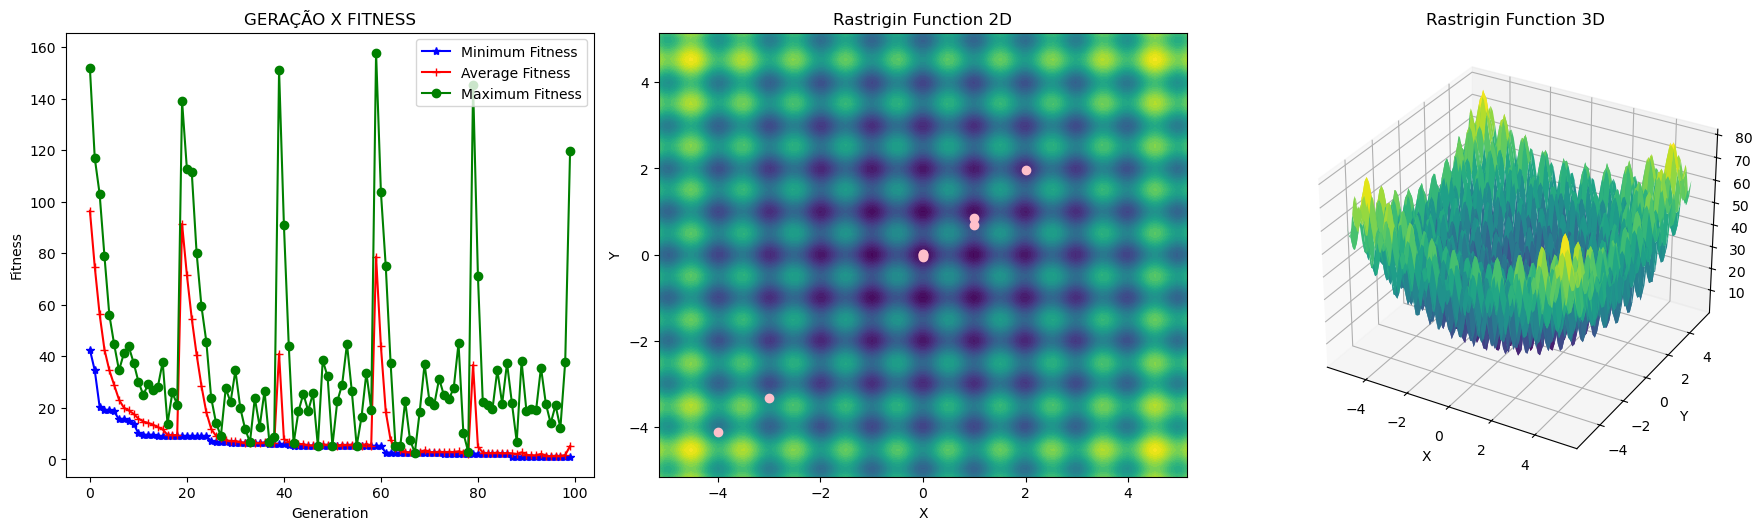

Soluções do problema

Best solution index =  87

Best solution variables =
 [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 4.769598369472904, -4.11482641196203, 3.667808970517254, 1.0387100847911368, 0.6962870941618178]

Best solution fitness =  1.0386193553481675

Ótimo global da função Rastrigin =  58.782409946599536

Solução ótima global =  [-2.92451474e-03 -1.92917318e-03  1.58397348e-02 -1.10191917e-02
  4.45818785e-03  4.97432102e+00 -3.97951543e+00  3.97935156e+00
  9.94727830e-01  9.94979165e-01]

Porcentagem de proximidade da solução em relação ao ótimo global =  98.23311198657609 %

Distância da solução em relação ao ótimo global = <built-in function abs>


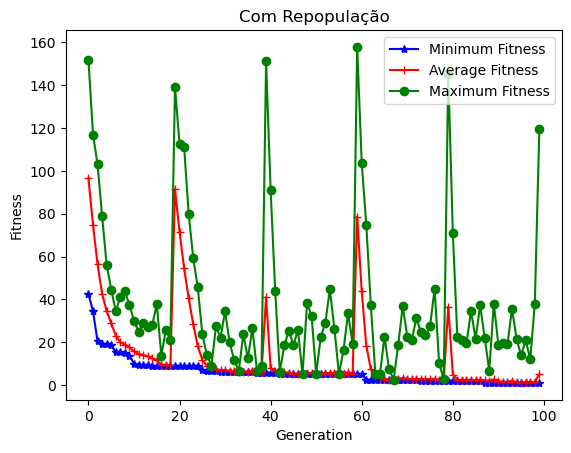

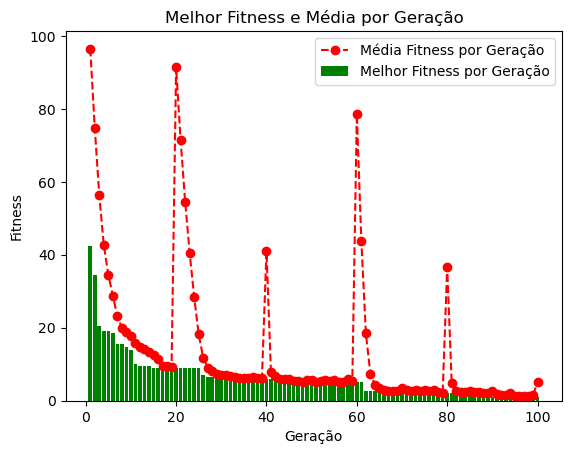

,Generation,Min Fitness,Average Fitness,Max Fitness,Std Fitness
0,0,42.469074,96.477455,151.722017,23.797127
1,1,34.486640,74.700551,116.910905,19.091674
2,2,20.404125,56.305085,103.037554,18.043919
3,3,19.008923,42.558039,78.839147,11.121337
4,4,19.008923,34.577393,56.116412,7.640166
...,...,...,...,...,...
95,95,1.038619,1.168002,13.934509,1.283089
96,96,1.038619,1.388169,20.941294,2.460320
97,97,1.038619,1.265021,12.115199,1.527238
98,98,1.038619,1.634638,37.911449,4.065974


Total execution time: 5.12 seconds


In [83]:


if __name__ == "__main__":
    tempo1 = time.time()

    # Setup
    params = load_params("/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json")
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()

    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y,data_hora,curva,vento),
    )

    print("\n\nEvolução concluída  - 100%")

    # Salvar resultados
    alg.cout("---> RESULTADOS OBTIDOS")
    data_visual.displayDataFrameInfo(alg.allIndividualValuesArray, "Todos Individuos Gerados")
    # data_visual.show_conjuntoElite(alg.pop_RCE)


    # Visualização dos resultados
    alg.cout("VISUALIZANDO OS RESULTADOS")
    data_visual.show_rastrigin_benchmark(logbook_with_repopulation,best_variables)
    data_visual.visualize(
        logbook_with_repopulation, pop_with_repopulation, repopulation=True
    )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)

    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")


 

In [117]:
def linear_search(populacao, criterio, *args):
    individuos_selecionados = []

    for individuo in populacao:
        if criterio(individuo, *args):
            if individuo not in individuos_selecionados:
                if all(elemento in individuos_selecionados for elemento in individuo):
                    individuos_selecionados.append(individuo)

    return individuos_selecionados



# criterio 2 - verificar se todos os elementos estão
print("\n\nComparando variáveis de decisao")
lista = []
conjunto = set()
for i in range(len(pop_with_repopulation)):

    diff = np.array(pop_with_repopulation[i]) - np.array(pop_with_repopulation[1+1])

    if sum(diff) > 8:
        if (pop_with_repopulation[i] not in lista) and (pop_with_repopulation[i] not in pop_with_repopulation[1+1]):
            print("\nIndividuo adicionado", pop_with_repopulation[i])
            lista.append(pop_with_repopulation[i])
            conjunto.add(tuple(pop_with_repopulation[i]))
            print("Delta= ",sum(diff))

print(len(lista))
print(len(conjunto))



Comparando variáveis de decisao

Individuo adicionado [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 4.858256519828339, -4.11482641196203, 3.667808970517254, 1.9510260602049092, 0.6962870941618178]
Delta 11.01121246881262

Individuo adicionado [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 4.858256519828339, -4.11482641196203, 3.667808970517254, 1.0387100847911368, 0.6962870941618178]
Delta 10.098896493398847

Individuo adicionado [-0.05701341467946418, -0.042758126403763475, 0.0122070977694122, -0.005788843794026999, 0.00439370503658423, 4.769598369472904, -4.11482641196203, 3.667808970517254, 1.0387100847911368, 0.6962870941618178]
Delta 10.010238343043412

Individuo adicionado [1.5638415243079722, -1.0375779740470286, -3.9533965686506645, 2.1167507823126206, -0.07368639413557876, 4.958477652976991, 1.5179608278434173, 1.3225822020700972, 4.3151219772619465,